## Importing some necessary packages. 

### Note

You'll need transformers from Huggingface to run this notebook. 

In [14]:
import time
from transformers import Trainer
import sys
import os
import math
from transformers.debug_utils import DebugOption, DebugUnderflowOverflow

from transformers.utils import(
    is_sagemaker_mp_enabled,
    is_torch_tpu_available,
    logging,
)
from tqdm.auto import tqdm
from transformers.deepspeed import deepspeed_init
from transformers.trainer_utils import(
    HPSearchBackend,
    ShardedDDPOption,
    TrainOutput,
    has_length,
    speed_metrics,
)
from transformers.trainer_pt_utils import IterableDatasetShard

from transformers.pytorch_utils import is_torch_less_than_1_11
from transformers.integrations import hp_params


import torch.distributed as dist

from transformers.trainer_callback import TrainerState
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler

import numpy as np
from datasets import load_metric
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import TrainingArguments
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from huggingface_hub import notebook_login
from datasets import load_dataset


TRAINING_ARGS_NAME = "training_args.bin"
TRAINER_STATE_NAME = "trainer_state.json"
OPTIMIZER_NAME = "optimizer.pt"
SCHEDULER_NAME = "scheduler.pt"
SCALER_NAME = "scaler.pt"

## Custom Trainer and inner_training_loop

In [15]:
class CustomTrainer(Trainer):
    def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
        self._train_batch_size = batch_size
        # Data loader and number of training steps
        train_dataloader = self.get_train_dataloader()

        # Setting up training control variables:
        # number of training epochs: num_train_epochs
        # number of training steps per epoch: num_update_steps_per_epoch
        # total number of training steps to execute: max_steps
        total_train_batch_size = args.train_batch_size * args.gradient_accumulation_steps * args.world_size

        len_dataloader = None
        if has_length(train_dataloader):
            len_dataloader = len(train_dataloader)
            num_update_steps_per_epoch = len_dataloader // args.gradient_accumulation_steps
            num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
            num_examples = self.num_examples(train_dataloader)
            if args.max_steps > 0:
                max_steps = args.max_steps
                num_train_epochs = args.max_steps // num_update_steps_per_epoch + int(
                    args.max_steps % num_update_steps_per_epoch > 0
                )
                # May be slightly incorrect if the last batch in the training dataloader has a smaller size but it's
                # the best we can do.
                num_train_samples = args.max_steps * total_train_batch_size
            else:
                max_steps = math.ceil(args.num_train_epochs * num_update_steps_per_epoch)
                num_train_epochs = math.ceil(args.num_train_epochs)
                num_train_samples = self.num_examples(train_dataloader) * args.num_train_epochs
        elif args.max_steps > 0:  # Rely on max_steps when dataloader does not have a working size
            max_steps = args.max_steps
            # Setting a very large number of epochs so we go as many times as necessary over the iterator.
            num_train_epochs = sys.maxsize
            num_update_steps_per_epoch = max_steps
            num_examples = total_train_batch_size * args.max_steps
            num_train_samples = args.max_steps * total_train_batch_size
        else:
            raise ValueError(
                "args.max_steps must be set to a positive value if dataloader does not have a length, was"
                f" {args.max_steps}"
            )

        if DebugOption.UNDERFLOW_OVERFLOW in self.args.debug:
            if self.args.n_gpu > 1:
                # nn.DataParallel(model) replicates the model, creating new variables and module
                # references registered here no longer work on other gpus, breaking the module
                raise ValueError(
                    "Currently --debug underflow_overflow is not supported under DP. Please use DDP"
                    " (torch.distributed.launch)."
                )
            else:
                debug_overflow = DebugUnderflowOverflow(self.model)  # noqa

        delay_optimizer_creation = (
            self.sharded_ddp is not None
            and self.sharded_ddp != ShardedDDPOption.SIMPLE
            or is_sagemaker_mp_enabled()
            or self.fsdp is not None
        )
        if args.deepspeed:
            deepspeed_engine, optimizer, lr_scheduler = deepspeed_init(
                self, num_training_steps=max_steps, resume_from_checkpoint=resume_from_checkpoint
            )
            self.model = deepspeed_engine.module
            self.model_wrapped = deepspeed_engine
            self.deepspeed = deepspeed_engine
            self.optimizer = optimizer
            self.lr_scheduler = lr_scheduler
        elif not delay_optimizer_creation:
            self.create_optimizer_and_scheduler(num_training_steps=max_steps)

        self.state = TrainerState()
        self.state.is_hyper_param_search = trial is not None

        # Activate gradient checkpointing if needed
        if args.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        model = self._wrap_model(self.model_wrapped)

        if is_sagemaker_mp_enabled() and resume_from_checkpoint is not None:
            self._load_from_checkpoint(resume_from_checkpoint, model)

        # for the rest of this function `model` is the outside model, whether it was wrapped or not
        if model is not self.model:
            self.model_wrapped = model

        if delay_optimizer_creation:
            self.create_optimizer_and_scheduler(num_training_steps=max_steps)

        # Check if saved optimizer or scheduler states exist
        self._load_optimizer_and_scheduler(resume_from_checkpoint)

        self.state.epoch = 0
        start_time = time.time()
        epochs_trained = 0
        steps_trained_in_current_epoch = 0
        steps_trained_progress_bar = None

        # Check if continuing training from a checkpoint
        if resume_from_checkpoint is not None and os.path.isfile(
            os.path.join(resume_from_checkpoint, TRAINER_STATE_NAME)
        ):
            self.state = TrainerState.load_from_json(os.path.join(resume_from_checkpoint, TRAINER_STATE_NAME))
            epochs_trained = self.state.global_step // num_update_steps_per_epoch
            if not args.ignore_data_skip:
                steps_trained_in_current_epoch = self.state.global_step % (num_update_steps_per_epoch)
                steps_trained_in_current_epoch *= args.gradient_accumulation_steps
            else:
                steps_trained_in_current_epoch = 0


            if not args.ignore_data_skip:
                if self.is_local_process_zero() and not args.disable_tqdm:
                    steps_trained_progress_bar = tqdm(total=steps_trained_in_current_epoch)
                    steps_trained_progress_bar.set_description("Skipping the first batches")

        # Update the references
        self.callback_handler.model = self.model
        self.callback_handler.optimizer = self.optimizer
        self.callback_handler.lr_scheduler = self.lr_scheduler
        self.callback_handler.train_dataloader = train_dataloader
        self.state.trial_name = self.hp_name(trial) if self.hp_name is not None else None
        if trial is not None:
            assignments = trial.assignments if self.hp_search_backend == HPSearchBackend.SIGOPT else trial
            self.state.trial_params = hp_params(assignments)
        else:
            self.state.trial_params = None
        # This should be the same if the state has been saved but in case the training arguments changed, it's safer
        # to set this after the load.
        self.state.max_steps = max_steps
        self.state.num_train_epochs = num_train_epochs
        self.state.is_local_process_zero = self.is_local_process_zero()
        self.state.is_world_process_zero = self.is_world_process_zero()

        # tr_loss is a tensor to avoid synchronization of TPUs through .item()
        tr_loss = torch.tensor(0.0).to(args.device)
        # _total_loss_scalar is updated everytime .item() has to be called on tr_loss and stores the sum of all losses
        self._total_loss_scalar = 0.0
        self._globalstep_last_logged = self.state.global_step
        model.zero_grad()

        self.control = self.callback_handler.on_train_begin(args, self.state, self.control)

        # Skip the first epochs_trained epochs to get the random state of the dataloader at the right point.
        if not args.ignore_data_skip:
            for epoch in range(epochs_trained):
                is_random_sampler = hasattr(train_dataloader, "sampler") and isinstance(
                    train_dataloader.sampler, RandomSampler
                )
                if is_torch_less_than_1_11 or not is_random_sampler:
                    # We just need to begin an iteration to create the randomization of the sampler.
                    # That was before PyTorch 1.11 however...
                    for _ in train_dataloader:
                        break
                else:
                    # Otherwise we need to call the whooooole sampler cause there is some random operation added
                    # AT THE VERY END!
                    _ = list(train_dataloader.sampler)

        for epoch in range(epochs_trained, num_train_epochs):
            if isinstance(train_dataloader, DataLoader) and isinstance(train_dataloader.sampler, DistributedSampler):
                train_dataloader.sampler.set_epoch(epoch)
            elif hasattr(train_dataloader, "dataset") and isinstance(train_dataloader.dataset, IterableDatasetShard):
                train_dataloader.dataset.set_epoch(epoch)


         
            epoch_iterator = train_dataloader

            # Reset the past mems state at the beginning of each epoch if necessary.
            if args.past_index >= 0:
                self._past = None

            steps_in_epoch = (
                len(epoch_iterator)
                if len_dataloader is not None
                else args.max_steps * args.gradient_accumulation_steps
            )
            self.control = self.callback_handler.on_epoch_begin(args, self.state, self.control)

            if epoch == epochs_trained and resume_from_checkpoint is not None and steps_trained_in_current_epoch == 0:
                self._load_rng_state(resume_from_checkpoint)

            step = -1
            for step, inputs in enumerate(epoch_iterator):

                # Skip past any already trained steps if resuming training
                if steps_trained_in_current_epoch > 0:
                    steps_trained_in_current_epoch -= 1
                    if steps_trained_progress_bar is not None:
                        steps_trained_progress_bar.update(1)
                    if steps_trained_in_current_epoch == 0:
                        self._load_rng_state(resume_from_checkpoint)
                    continue
                elif steps_trained_progress_bar is not None:
                    steps_trained_progress_bar.close()
                    steps_trained_progress_bar = None

                if step % args.gradient_accumulation_steps == 0:
                    self.control = self.callback_handler.on_step_begin(args, self.state, self.control)

                if (
                    ((step + 1) % args.gradient_accumulation_steps != 0)
                    and args.local_rank != -1
                    and args._no_sync_in_gradient_accumulation
                ):
                    # Avoid unnecessary DDP synchronization since there will be no backward pass on this example.
                    with model.no_sync():
                        tr_loss_step = self.training_step(model, inputs)
                else:
                    tr_loss_step = self.training_step(model, inputs)

                if (
                    args.logging_nan_inf_filter
                    and not is_torch_tpu_available()
                    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
                ):
                    # if loss is nan or inf simply add the average of previous logged losses
                    tr_loss += tr_loss / (1 + self.state.global_step - self._globalstep_last_logged)
                else:
                    tr_loss += tr_loss_step

                self.current_flos += float(self.floating_point_ops(inputs))

                # Optimizer step for deepspeed must be called on every step regardless of the value of gradient_accumulation_steps
                if self.deepspeed:
                    self.deepspeed.step()

                if (step + 1) % args.gradient_accumulation_steps == 0 or (
                    # last step in epoch but step is always smaller than gradient_accumulation_steps
                    steps_in_epoch <= args.gradient_accumulation_steps
                    and (step + 1) == steps_in_epoch
                ):
                    # Gradient clipping
                    if args.max_grad_norm is not None and args.max_grad_norm > 0 and not self.deepspeed:
                        # deepspeed does its own clipping

                        if self.do_grad_scaling:
                            # Reduce gradients first for XLA
                            # AMP: gradients need unscaling
                            self.scaler.unscale_(self.optimizer)

                        if is_sagemaker_mp_enabled() and args.fp16:
                            self.optimizer.clip_master_grads(args.max_grad_norm)
                        elif hasattr(self.optimizer, "clip_grad_norm"):
                            # Some optimizers (like the sharded optimizer) have a specific way to do gradient clipping
                            self.optimizer.clip_grad_norm(args.max_grad_norm)
                        elif hasattr(model, "clip_grad_norm_"):
                            # Some models (like FullyShardedDDP) have a specific way to do gradient clipping
                            model.clip_grad_norm_(args.max_grad_norm)

                    # Optimizer step
                    optimizer_was_run = True
                    if self.deepspeed:
                        pass  # called outside the loop
 
                    elif self.do_grad_scaling:
                        scale_before = self.scaler.get_scale()
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                        scale_after = self.scaler.get_scale()
                        optimizer_was_run = scale_before <= scale_after
                    else:
                        self.optimizer.step()

                    if optimizer_was_run and not self.deepspeed:
                        self.lr_scheduler.step()

                    model.zero_grad()
                    self.state.global_step += 1
                    self.state.epoch = epoch + (step + 1) / steps_in_epoch
                    self.control = self.callback_handler.on_step_end(args, self.state, self.control)

                    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
                else:
                    self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

                if self.control.should_epoch_stop or self.control.should_training_stop:
                    break
            if step < 0:
                self.control.should_training_stop = True

            self.control = self.callback_handler.on_epoch_end(args, self.state, self.control)
            self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)

            if self.control.should_training_stop:
                break

        if args.past_index and hasattr(self, "_past"):
            # Clean the state at the end of training
            delattr(self, "_past")

        if args.load_best_model_at_end and self.state.best_model_checkpoint is not None:
            # Wait for everyone to get here so we are sur the model has been saved by process 0.
            if args.local_rank != -1:
                dist.barrier()

            self._load_best_model()

        # add remaining tr_loss
        self._total_loss_scalar += tr_loss.item()
        train_loss = self._total_loss_scalar / self.state.global_step

        metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
        self.store_flos()
        metrics["total_flos"] = self.state.total_flos
        metrics["train_loss"] = train_loss

        self.is_in_train = False

        self._memory_tracker.stop_and_update_metrics(metrics)

        self.log(metrics)

        self.control = self.callback_handler.on_train_end(args, self.state, self.control)

        return TrainOutput(self.state.global_step, train_loss, metrics)

## Train, validation and test split

I am randomly sampling 300 samples for validation and 100 samples for test as it would be easy during computation. The results were identical when compared to the whole validation or test dataset. 

In [16]:
current_seed = 26
dataset = load_dataset("sst2")
small_train_dataset = dataset["train"].shuffle(seed=current_seed)
small_valid_dataset = dataset["validation"].shuffle(seed=current_seed).select([i for i in list(range(300))])
small_test_dataset = dataset["test"].shuffle(seed = current_seed).select([i for i in list(range(100))])
dataset_df = small_train_dataset.to_pandas()
dataset_df.head()

Using custom data configuration default
Found cached dataset sst2 (C:/Users/harsh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:/Users/harsh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5\cache-f744d03767199530.arrow
Loading cached shuffled indices for dataset at C:/Users/harsh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5\cache-61613e45aec1481a.arrow
Loading cached shuffled indices for dataset at C:/Users/harsh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5\cache-2d2bf7f82bb32d80.arrow


,idx,sentence,label
0,60960,viewers are asked so often to suspend belief t...,0
1,8468,"while solondz tries and tries hard , storytell...",0
2,744,gets vivid performances from her cast and pull...,1
3,63786,old-fashioned but emotionally stirring adventu...,1
4,52711,of the big summer movies,1


In [17]:
 def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [18]:
notebook_login()

Login successful
Your token has been saved to C:\Users\harsh/.huggingface/token


## Preprocessing the Data. 

I am using Distilled BERT for sentiment classification, it is faster than BERT due to reduced model complexity and it also retains the most of the performance.

In [19]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_valid = small_valid_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

repo_name = "distilled_bert_finetune"

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\harsh/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\harsh/.cache\huggingface\transformers\0e1bbfda7f6

## Defining the arguments and trainer


Training for 10 epochs, with a learning rate of 0.00005 as finetuining requires low learning rate, and batch size of 16

In [20]:
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=1e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_valid,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## Start training

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
D:\anaconda\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss
500,0.352000
1000,0.256400
1500,0.241400
2000,0.211900
2500,0.199900
3000,0.182500
3500,0.176000
4000,0.181700
4500,0.152600
5000,0.120800


Saving model checkpoint to distilled_bert_finetune\checkpoint-4210
Configuration saved in distilled_bert_finetune\checkpoint-4210\config.json
Model weights saved in distilled_bert_finetune\checkpoint-4210\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-4210\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-4210\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-8420
Configuration saved in distilled_bert_finetune\checkpoint-8420\config.json
Model weights saved in distilled_bert_finetune\checkpoint-8420\pytorch_model.bin
tokenizer config file saved in distilled_bert_finetune\checkpoint-8420\tokenizer_config.json
Special tokens file saved in distilled_bert_finetune\checkpoint-8420\special_tokens_map.json
Saving model checkpoint to distilled_bert_finetune\checkpoint-12630
Configuration saved in distilled_bert_finetune\checkpoint-12630\config.json
Model weights saved in distilled_bert_

TrainOutput(global_step=42100, training_loss=0.0638630661941764, metrics={'train_runtime': 1650.6248, 'train_samples_per_second': 408.021, 'train_steps_per_second': 25.505, 'total_flos': 6126298438161984.0, 'train_loss': 0.0638630661941764, 'epoch': 10.0})

## Evaluate

In [22]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


{'eval_loss': 0.45846307277679443,
 'eval_accuracy': 0.91,
 'eval_f1': 0.9114754098360656,
 'eval_runtime': 1.7258,
 'eval_samples_per_second': 173.831,
 'eval_steps_per_second': 11.009,
 'epoch': 10.0}

## Pusing the model to the hub

In [23]:
#trainer.push_to_hub()

In [24]:
def process_pred_batch(prediction_batch):
    pred_labels = []
    for i in range(len(prediction_batch)):
        if prediction_batch[i]["label"] == "LABEL_1":
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    
    return pred_labels

true_labels = []
pred_labels = []

sentiment_model = pipeline("text-classification", model="C:/Users/harsh/OneDrive/Desktop/HW1/distilled_bert_finetune/checkpoint-42100")

loading configuration file C:/Users/harsh/OneDrive/Desktop/HW1/distilled_bert_finetune/checkpoint-42100\config.json
Model config DistilBertConfig {
  "_name_or_path": "C:/Users/harsh/OneDrive/Desktop/HW1/distilled_bert_finetune/checkpoint-42100",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading configuration file C:/Users/harsh/OneDrive/Desktop/HW1/distilled_bert_finetune/checkpoint-42100\config.json
Model config DistilBertConfig {
  "_name_or_path": "C:/Users/harsh/On

In [25]:
import time

wrong_sentences = []

start = time.time()

for index, item in enumerate(small_valid_dataset):
    test_sentence = item['sentence']
    output = sentiment_model(test_sentence)
    prediction = process_pred_batch(output)
    if prediction[0]!=item['label']:
        if prediction[0]==1:
            label_string = "positive"
        else:
            label_string = "negative"
        wrong_sentences.append({"sentence": test_sentence, 
                               "wrong_label_assigned": label_string})
    #print(prediction, item['label'])
    true_labels.append(item['label'])
    pred_labels.extend(prediction)

end = time.time()
average = (end - start)/index
print("Average compute time for a sample: {}".format(average))

Average compute time for a sample: 0.016945938601541678


In [26]:
len(true_labels), len(pred_labels)

(300, 300)

# Sentence Analysis for Wrong Words

Let's take a quick look at the False positives and False negatives from the model. 

In [27]:
wrong_sentences

[{'sentence': "it 's somewhat clumsy and too lethargically paced -- but its story about a mysterious creature with psychic abilities offers a solid build-up , a terrific climax , and some nice chills along the way . ",
  'wrong_label_assigned': 'positive'},
 {'sentence': 'drops you into a dizzying , volatile , pressure-cooker of a situation that quickly snowballs out of control , while focusing on the what much more than the why . ',
  'wrong_label_assigned': 'negative'},
 {'sentence': 'jason x is positively anti-darwinian : nine sequels and 400 years later , the teens are none the wiser and jason still kills on auto-pilot . ',
  'wrong_label_assigned': 'positive'},
 {'sentence': 'this flick is about as cool and crowd-pleasing as a documentary can get . ',
  'wrong_label_assigned': 'negative'},
 {'sentence': 'good film , but very glum . ',
  'wrong_label_assigned': 'negative'},
 {'sentence': 'but it still jingles in the pocket . ',
  'wrong_label_assigned': 'negative'},
 {'sentence': "

## Compute metrics from the confusion matrix

In [28]:
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)


print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("f1: {}".format(f1))
print("accuracy: {}".format(accuracy))

precision: 0.896774193548387
recall: 0.9266666666666666
f1: 0.9114754098360656
accuracy: 0.91


## Final Observation and the Baseline

The metric used in the leaderboard in PaperswithCode on Sentiment Analysis on SST-2 Binary classification is **accuracy** and the reported accuracy is **91.3** and the results match the leaderboard performance.  

* precision: 0.90
* recall: 0.92
* f1: 0.91
* accuracy: 0.91

## working on the exported log file to plot loss vs steps plot.

In [29]:
f = open("C:/Users/harsh/OneDrive/Desktop/HW1/logs.txt", "r")
steps = []
loss = []
for x in f:
    x = x.strip().split("	")
    steps.append(int(x[0]))
    loss.append(float(x[1]))

## NOTE: I am removing step numbers from X-axis as the numbers are too large for the plot, so the x-axis doesn't make much sense. 

### If you plan to include it, uncomment the line ``plt.xticks(xi, steps)''

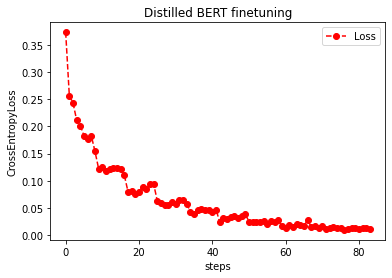

In [30]:
import matplotlib.pyplot as plt

xi = list(range(len(steps)))

plt.plot(xi, loss, marker='o', linestyle='--', color='r', label='Loss') 
plt.xlabel('steps')
plt.ylabel('CrossEntropyLoss') 
#plt.xticks(xi, steps)
plt.title('Distilled BERT finetuning')
plt.legend() 
plt.show()

Link to the WandB chart. 


**Link**: https://wandb.ai/harbat/huggingface/reports/train-loss-22-10-14-17-07-50---VmlldzoyNzk1OTg2?accessToken=cududirgdq79fkkae2tqf48tglc962aqs2idfxrq3k1fnpwflr29b4rcss15a9pk


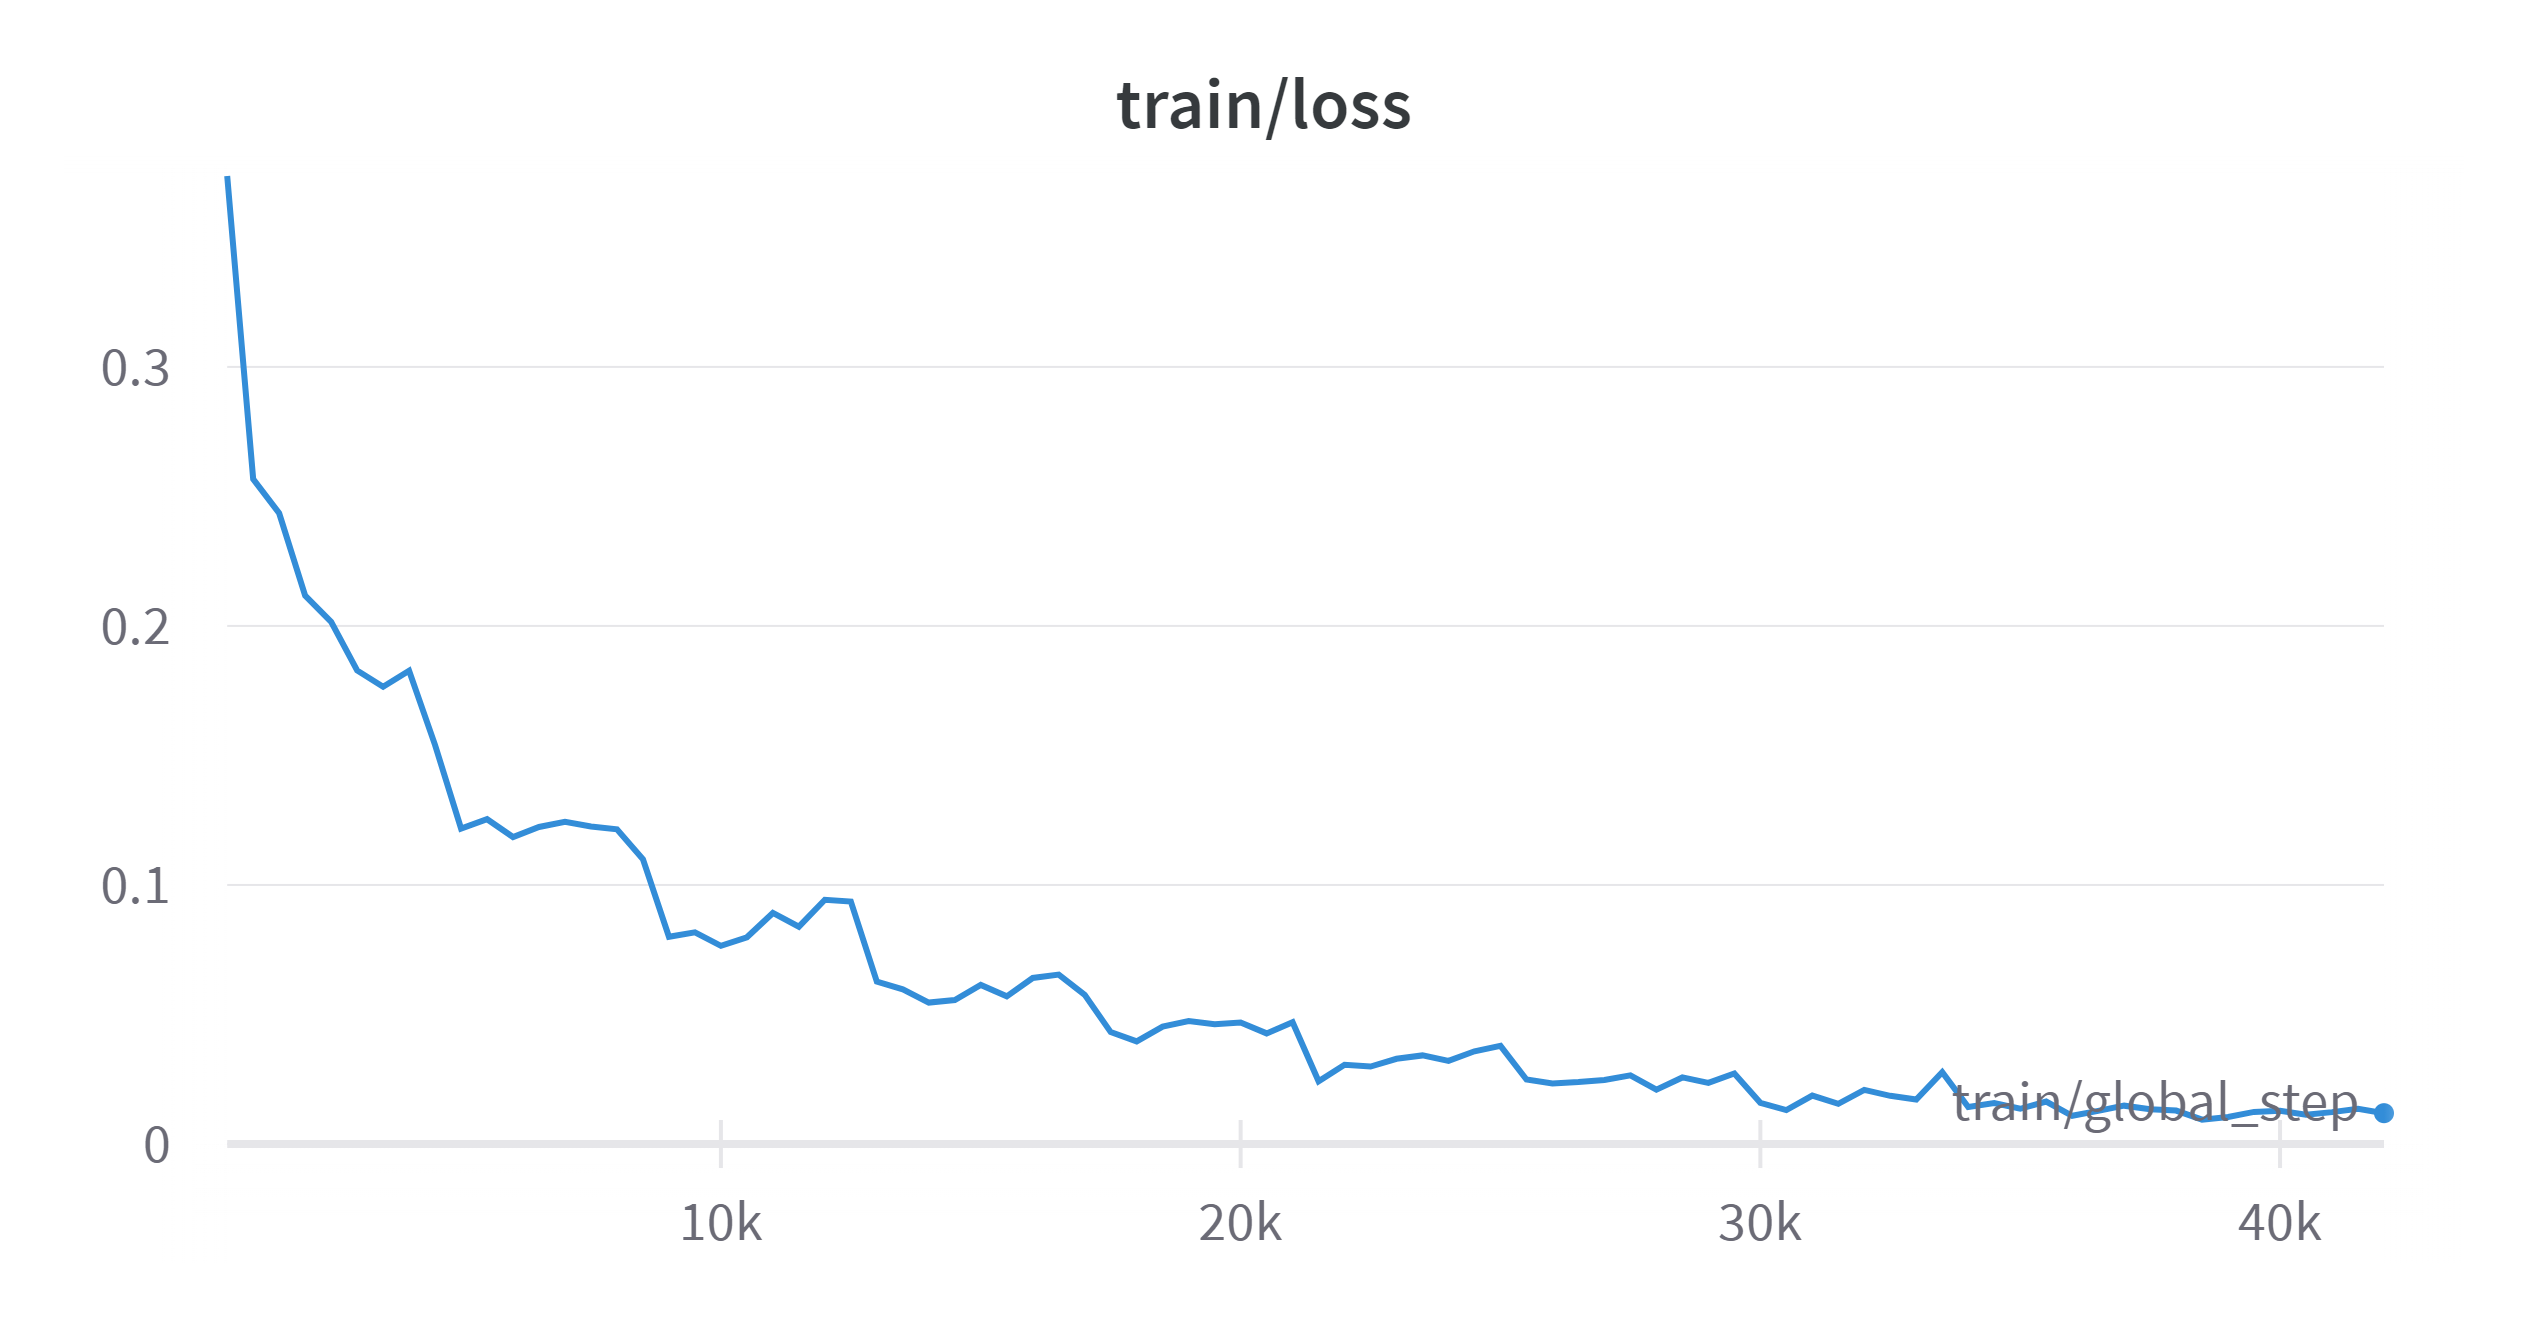

In [31]:
from IPython.display import Image
Image(filename='C:/Users/harsh/OneDrive/Desktop/HW1/imgs/W&B_Chart.png')